In [1]:
# Install packages
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn import feature_selection

In [2]:
# load data
df = pd.read_csv('mbti_preprocessed_features.csv', index_col= 0)

In [3]:
def create_train_test_split(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42069)
    return X_train, X_test, Y_train, Y_test

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [5]:
feature = ['avg_word_count', 'avg_exclam_count', 'avg_fullstop_count', 'avg_count_of_hello', 'avg_count_of_hi', 'avg_count_of_extroverted_bigrams', 'avg_count_of_extroverted_stylistic_impressions',	'avg_count_of_interoverted_quantifiers',	'avg_count_of_introverted_first_person_singular_pronoun',	'avg_count_of_introverted_negations']

c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Classification Report:
              precision    recall  f1-score   support

 Introverted       0.84      0.94      0.89      2002
 Extroverted       0.68      0.41      0.51       601

    accuracy                           0.82      2603
   macro avg       0.76      0.68      0.70      2603
weighted avg       0.80      0.82      0.80      2603

0.819439108720707


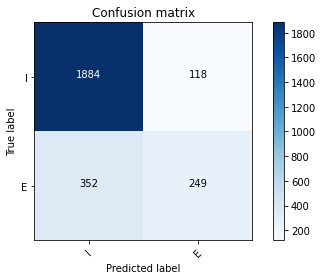

In [6]:
# Binary + Feautres - Unbalanced
# Extro - Intro

# Determine X and Y
X = df[['preprocessed_posts', 'avg_word_count', 'avg_exclam_count', 'avg_fullstop_count', 'avg_count_of_hello', 'avg_count_of_hi', 'avg_count_of_extroverted_bigrams', 'avg_count_of_extroverted_stylistic_impressions',	'avg_count_of_interoverted_quantifiers',	'avg_count_of_introverted_first_person_singular_pronoun',	'avg_count_of_introverted_negations' ]] #Preprocessed_posts #Preprocessed_Posts + Features
Y = df.iloc[:, 4].values #Extro-Intro

# Create splits
X_train_EI, X_test_EI, Y_train_EI, Y_test_EI = create_train_test_split(X, Y)

## TF-IDF
vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.3, max_features=10000)

##Extract Vocabulary
corpus = X_train_EI["preprocessed_posts"].values.astype(str)
vectorizer.fit(corpus)
X_training = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
# print("Training vocabulary size before dimension reduction: " + str(len(dic_vocabulary)))

# Feature Selection

##Reduce Dimensionality for sparse data with Chi-Quadrat
X_names = vectorizer.get_feature_names_out()
p_value_limit = 0.95
features = pd.DataFrame()
# print("Top Features for Each Class:")
for cat in np.unique(Y_train_EI):
    chi2, p = feature_selection.chi2(X_training, Y_train_EI == cat)
    features = features.append(pd.DataFrame(
        {"feature": X_names, "score": 1 - p, "y": cat}))
    features = features.sort_values(["y", "score"], ascending=[True, False])
    features = features[features["score"] > p_value_limit]
X_names = features["feature"].unique().tolist()

##Re-Fit vectorizer on corpus with new set of words and create new sparse matrix
vectorizer = TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)

df_tfidfvect_IE = vectorizer.transform(corpus)
df_tfidfvect_IE = hstack([df_tfidfvect_IE, X_train_EI[feature]])
tfidf_tokens_IE = vectorizer.get_feature_names()
df_tfidfvect_IE = pd.DataFrame(data = df_tfidfvect_IE.toarray(),columns = tfidf_tokens_IE + feature)

# Normalise Features
scaler = MinMaxScaler()
df_tfidfvect_IE[feature] = scaler.fit_transform(df_tfidfvect_IE[feature])

corpus = X_test_EI["preprocessed_posts"].values.astype(str)
df_tfidfvect_test_IE = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

df_tfidfvect_test_IE = hstack([df_tfidfvect_test_IE, X_test_EI[feature]])
tfidf_tokens_test_IE = vectorizer.get_feature_names()
df_tfidfvect_test_IE = pd.DataFrame(data = df_tfidfvect_test_IE.toarray(),columns = tfidf_tokens_test_IE + feature)

# Normalise Features
df_tfidfvect_test_IE[feature] = scaler.transform(df_tfidfvect_test_IE[feature])

# Train Model
rf = RandomForestClassifier()
rf = rf.fit(df_tfidfvect_IE, Y_train_EI)

# Prediction & Evaluation
prediction_EI = rf.predict(df_tfidfvect_test_IE)

types = ['Introverted', 'Extroverted']

print("Classification Report:")
print(classification_report(Y_test_EI, prediction_EI, target_names=types))
print(sklearn.metrics.f1_score(Y_test_EI, prediction_EI, average ='micro'))

# Confusion Matrix
cnf = confusion_matrix(Y_test_EI, prediction_EI)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = ['I','E'])

c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Classification Report:
              precision    recall  f1-score   support

     Sensing       0.58      0.27      0.37       342
   Intuition       0.90      0.97      0.93      2261

    accuracy                           0.88      2603
   macro avg       0.74      0.62      0.65      2603
weighted avg       0.86      0.88      0.86      2603

0.8786016135228583


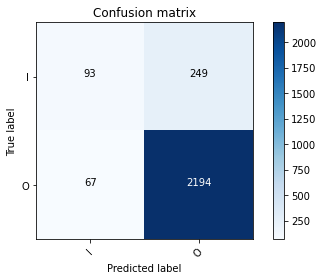

In [7]:
# Binary Sensing-Intuition - Balanced

# Determine X and Y 
X = df[['preprocessed_posts', 'avg_word_count', 'avg_exclam_count', 'avg_fullstop_count', 'avg_count_of_hello', 'avg_count_of_hi', 'avg_count_of_extroverted_bigrams', 'avg_count_of_extroverted_stylistic_impressions',	'avg_count_of_interoverted_quantifiers',	'avg_count_of_introverted_first_person_singular_pronoun',	'avg_count_of_introverted_negations' ]] #Preprocessed_posts #Preprocessed_Posts + Features
Y = df.iloc[:, 5].values #intu-obs

# Create splits
X_train_IO, X_test_IO, Y_train_IO, Y_test_IO = create_train_test_split(X, Y)

## TF-IDF
vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.3, max_features=10000)

##Extract Vocabulary
corpus = X_train_IO["preprocessed_posts"].values.astype(str)
vectorizer.fit(corpus)
X_training = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
# print("Training vocabulary size before dimension reduction: " + str(len(dic_vocabulary)))

# Feature Selection

##Reduce Dimensionality for sparse data with Chi-Quadrat
X_names = vectorizer.get_feature_names_out()
p_value_limit = 0.95
features = pd.DataFrame()
# print("Top Features for Each Class:")
for cat in np.unique(Y_train_IO):
    chi2, p = feature_selection.chi2(X_training, Y_train_IO == cat)
    features = features.append(pd.DataFrame(
        {"feature": X_names, "score": 1 - p, "y": cat}))
    features = features.sort_values(["y", "score"], ascending=[True, False])
    features = features[features["score"] > p_value_limit]
X_names = features["feature"].unique().tolist()

##Re-Fit vectorizer on corpus with new set of words and create new sparse matrix
vectorizer = TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)

df_tfidfvect_IO = vectorizer.transform(corpus)
df_tfidfvect_IO = hstack([df_tfidfvect_IO, X_train_IO[feature]])
tfidf_tokens_IO = vectorizer.get_feature_names()
df_tfidfvect_IO = pd.DataFrame(data = df_tfidfvect_IO.toarray(),columns = tfidf_tokens_IO + feature)

# Normalise Features
scaler = MinMaxScaler()
df_tfidfvect_IO[feature] = scaler.fit_transform(df_tfidfvect_IO[feature])

corpus = X_test_IO["preprocessed_posts"].values.astype(str)
df_tfidfvect_test_IO = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

df_tfidfvect_test_IO = hstack([df_tfidfvect_test_IO, X_test_IO[feature]])
tfidf_tokens_test_IO = vectorizer.get_feature_names()
df_tfidfvect_test_IO = pd.DataFrame(data = df_tfidfvect_test_IO.toarray(),columns = tfidf_tokens_test_IO + feature)

# Normalise Features
df_tfidfvect_test_IO[feature] = scaler.transform(df_tfidfvect_test_IO[feature])

# Train Model
rf = RandomForestClassifier()
rf = rf.fit(df_tfidfvect_IO, Y_train_IO)

# Prediction & Evaluation
prediction_IO = rf.predict(df_tfidfvect_test_IO)

types = ['Sensing', 'Intuition']

print("Classification Report:")
print(classification_report(Y_test_IO, prediction_IO, target_names=types))
print(sklearn.metrics.f1_score(Y_test_IO, prediction_IO, average ='micro'))

# Confusion Matrix
cnf = confusion_matrix(Y_test_IO, prediction_IO)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = ['I','O'])

c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Classification Report:
              precision    recall  f1-score   support

    Thinking       0.78      0.74      0.76      1199
     Feeling       0.79      0.82      0.81      1404

    accuracy                           0.79      2603
   macro avg       0.79      0.78      0.78      2603
weighted avg       0.79      0.79      0.79      2603

0.7856319631194775


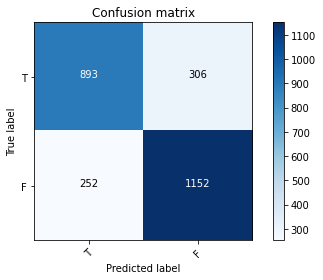

In [8]:
# Binary Thinking-Feeling - Balanced

# Determine X and Y 
X = df[['preprocessed_posts', 'avg_word_count', 'avg_exclam_count', 'avg_fullstop_count', 'avg_count_of_hello', 'avg_count_of_hi', 'avg_count_of_extroverted_bigrams', 'avg_count_of_extroverted_stylistic_impressions',	'avg_count_of_interoverted_quantifiers',	'avg_count_of_introverted_first_person_singular_pronoun',	'avg_count_of_introverted_negations' ]] #Preprocessed_posts #Preprocessed_Posts + Features
Y = df.iloc[:, 6].values # think - feel

# Create splits
X_train_TF, X_test_TF, Y_train_TF, Y_test_TF = create_train_test_split(X, Y)

## TF-IDF
vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.3, max_features=10000)

##Extract Vocabulary
corpus = X_train_TF["preprocessed_posts"].values.astype(str)
vectorizer.fit(corpus)
X_training = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
# print("Training vocabulary size before dimension reduction: " + str(len(dic_vocabulary)))

# Feature Selection

##Reduce Dimensionality for sparse data with Chi-Quadrat
X_names = vectorizer.get_feature_names_out()
p_value_limit = 0.95
features = pd.DataFrame()
# print("Top Features for Each Class:")
for cat in np.unique(Y_train_TF):
    chi2, p = feature_selection.chi2(X_training, Y_train_TF == cat)
    features = features.append(pd.DataFrame(
        {"feature": X_names, "score": 1 - p, "y": cat}))
    features = features.sort_values(["y", "score"], ascending=[True, False])
    features = features[features["score"] > p_value_limit]
X_names = features["feature"].unique().tolist()

##Re-Fit vectorizer on corpus with new set of words and create new sparse matrix
vectorizer = TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)

df_tfidfvect_TF = vectorizer.transform(corpus)
df_tfidfvect_TF = hstack([df_tfidfvect_TF, X_train_TF[feature]])
tfidf_tokens_TF = vectorizer.get_feature_names()
df_tfidfvect_TF = pd.DataFrame(data = df_tfidfvect_TF.toarray(),columns = tfidf_tokens_TF + feature)

# Normalise Features
scaler = MinMaxScaler()
df_tfidfvect_TF[feature] = scaler.fit_transform(df_tfidfvect_TF[feature])

corpus = X_test_TF["preprocessed_posts"].values.astype(str)
df_tfidfvect_test_TF = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

df_tfidfvect_test_TF = hstack([df_tfidfvect_test_TF, X_test_TF[feature]])
tfidf_tokens_test_TF = vectorizer.get_feature_names()
df_tfidfvect_test_TF = pd.DataFrame(data = df_tfidfvect_test_TF.toarray(),columns = tfidf_tokens_test_TF + feature)

# Normalise Features
df_tfidfvect_test_TF[feature] = scaler.transform(df_tfidfvect_test_TF[feature])


# Train Model
rf = RandomForestClassifier()
rf = rf.fit(df_tfidfvect_TF, Y_train_TF)

# Prediction & Evaluation
prediction_TF = rf.predict(df_tfidfvect_test_TF)

types = ['Thinking', 'Feeling']

print("Classification Report:")
print(classification_report(Y_test_TF, prediction_TF, target_names=types))
print(sklearn.metrics.f1_score(Y_test_TF, prediction_TF, average ='micro'))

# Confusion Matrix
cnf = confusion_matrix(Y_test_TF, prediction_TF)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = ['T','F'])

c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Classification Report:
              precision    recall  f1-score   support

     Judging       0.75      0.63      0.69      1071
  Perceiving       0.77      0.85      0.81      1532

    accuracy                           0.76      2603
   macro avg       0.76      0.74      0.75      2603
weighted avg       0.76      0.76      0.76      2603

0.7602766039185554


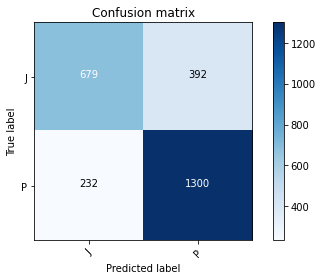

In [10]:
# Binary Judging-Perceiving - Balanced

# Determine X and Y 
X = df[['preprocessed_posts', 'avg_word_count', 'avg_exclam_count', 'avg_fullstop_count', 'avg_count_of_hello', 'avg_count_of_hi', 'avg_count_of_extroverted_bigrams', 'avg_count_of_extroverted_stylistic_impressions',	'avg_count_of_interoverted_quantifiers',	'avg_count_of_introverted_first_person_singular_pronoun',	'avg_count_of_introverted_negations' ]] #Preprocessed_posts #Preprocessed_Posts + Features
Y = df.iloc[:, 7].values # think - feel

# Create splits
X_train_JP, X_test_JP, Y_train_JP, Y_test_JP = create_train_test_split(X, Y)

## TF-IDF
vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.3, max_features=10000)

##Extract Vocabulary
corpus = X_train_JP["preprocessed_posts"].values.astype(str)
vectorizer.fit(corpus)
X_training = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
# print("Training vocabulary size before dimension reduction: " + str(len(dic_vocabulary)))

# Feature Selection

##Reduce Dimensionality for sparse data with Chi-Quadrat
X_names = vectorizer.get_feature_names_out()
p_value_limit = 0.95
features = pd.DataFrame()
# print("Top Features for Each Class:")
for cat in np.unique(Y_train_JP):
    chi2, p = feature_selection.chi2(X_training, Y_train_JP == cat)
    features = features.append(pd.DataFrame(
        {"feature": X_names, "score": 1 - p, "y": cat}))
    features = features.sort_values(["y", "score"], ascending=[True, False])
    features = features[features["score"] > p_value_limit]
X_names = features["feature"].unique().tolist()

##Re-Fit vectorizer on corpus with new set of words and create new sparse matrix
vectorizer = TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)

df_tfidfvect_JP = vectorizer.transform(corpus)
df_tfidfvect_JP = hstack([df_tfidfvect_JP, X_train_JP[feature]])
tfidf_tokens_JP = vectorizer.get_feature_names()
df_tfidfvect_JP = pd.DataFrame(data = df_tfidfvect_JP.toarray(),columns = tfidf_tokens_JP + feature)

# Normalise Features
scaler = MinMaxScaler()
df_tfidfvect_JP[feature] = scaler.fit_transform(df_tfidfvect_JP[feature])

corpus = X_test_TF["preprocessed_posts"].values.astype(str)
df_tfidfvect_test_JP = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

df_tfidfvect_test_JP = hstack([df_tfidfvect_test_JP, X_test_JP[feature]])
tfidf_tokens_test_JP = vectorizer.get_feature_names()
df_tfidfvect_test_JP = pd.DataFrame(data = df_tfidfvect_test_JP.toarray(),columns = tfidf_tokens_test_JP + feature)

# Normalise Features
df_tfidfvect_test_JP[feature] = scaler.transform(df_tfidfvect_test_JP[feature])

# Train Model
rf = RandomForestClassifier()
rf = rf.fit(df_tfidfvect_JP, Y_train_JP)

# Prediction & Evaluation
prediction_JP = rf.predict(df_tfidfvect_test_JP)

types = ['Judging', 'Perceiving']

print("Classification Report:")
print(classification_report(Y_test_JP, prediction_JP, target_names=types))
print(sklearn.metrics.f1_score(Y_test_JP, prediction_JP, average ='micro'))

# Confusion Matrix
cnf = confusion_matrix(Y_test_JP, prediction_JP)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = ['J','P'])

In [11]:
# Combine the 4 Binary Models
df1 = df[['encodedType', 'extro_intro', 'intu_obs', 'feel_think', 'prosp_judg']].drop_duplicates().reset_index(drop=True)

Y_test_df = pd.DataFrame(np.transpose([Y_test_EI, Y_test_JP, Y_test_IO, Y_test_TF]), 
                         columns =['extro_intro', 'intu_obs', 'feel_think', 'prosp_judg'])
Y_test_df = Y_test_df.merge(df1, how = 'left', on = Y_test_df.columns.tolist())

predict_df = pd.DataFrame(np.transpose([prediction_EI, prediction_JP, prediction_IO, prediction_TF]), 
                         columns =['extro_intro', 'intu_obs', 'feel_think', 'prosp_judg'])
predict_df = predict_df.merge(df1, how = 'left', on = predict_df.columns.tolist())

print("Classification Report:")
print(classification_report(Y_test_df['encodedType'].values, predict_df['encodedType'].values))

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.51      0.53       196
           1       0.62      0.33      0.43       212
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00        14
           4       0.23      0.09      0.13        74
           5       0.27      0.16      0.20        55
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        11
           8       0.46      0.65      0.54       378
           9       0.49      0.68      0.57       545
          10       0.61      0.41      0.49        86
          11       0.17      0.11      0.13        73
          12       0.49      0.44      0.46       365
          13       0.53      0.57      0.55       436
          14       0.55      0.18      0.27        61
          15       0.52      0.21      0.30        58

    accuracy                           0.49      2603
   

c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

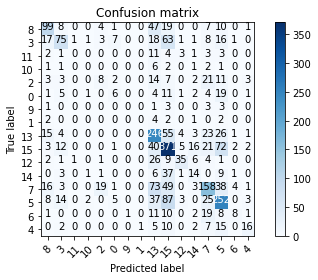

In [11]:
# plot confusion amtrix
cnf = confusion_matrix(Y_test_df['encodedType'].values, predict_df['encodedType'].values)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = df1['encodedType'])

In [12]:
# Hyperparameter Tuning
# CV Grid Search
random_grid = {
    'max_depth': [ 30, 60, 80],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [500, 1000, 1500],
    'criterion' :['gini', 'entropy'],
    'random_state': [42]
 }

In [13]:
rf_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=random_grid, cv= 3, n_jobs = -1)

In [16]:
# extro-intro
rf_cv_EI= rf_cv.fit(df_tfidfvect_IE, Y_train_EI)
print(rf_cv_EI.best_params_)

{'criterion': 'entropy', 'max_depth': 60, 'min_samples_split': 10, 'n_estimators': 1500, 'random_state': 42}


In [21]:
# Extro - Intro
# Train Model
rf = RandomForestClassifier(n_estimators = 1500, min_samples_split = 10,  max_features = 'sqrt', max_depth = 60, random_state = 42, criterion = 'entropy')
rf = rf.fit(df_tfidfvect_IE, Y_train_EI)

# Prediction & Evaluation
prediction_EI = rf.predict(df_tfidfvect_test_IE)

types = ['Introverted', 'Extroverted']

print("Classification Report:")
print(classification_report(Y_test_EI, prediction_EI, target_names=types))
print(sklearn.metrics.f1_score(Y_test_EI, prediction_EI, average ='micro'))

Classification Report:
              precision    recall  f1-score   support

 Introverted       0.85      0.94      0.89      2002
 Extroverted       0.68      0.43      0.53       601

    accuracy                           0.82      2603
   macro avg       0.76      0.68      0.71      2603
weighted avg       0.81      0.82      0.81      2603

0.822128313484441


In [17]:
# intu - ob
rf_cv_IO = rf_cv.fit(df_tfidfvect_IO, Y_train_IO)
print(rf_cv_IO.best_params_)

{'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 42}


In [22]:
# Sensing - Intuition
# Train Model
rf = RandomForestClassifier(n_estimators = 500, min_samples_split = 10,  max_features = 'sqrt', max_depth = 30, random_state = 42, criterion = 'gini')
rf = rf.fit(df_tfidfvect_IO, Y_train_IO)

# Prediction & Evaluation
prediction_IO = rf.predict(df_tfidfvect_test_IO)

types = ['Sensing', 'Intuition']

print("Classification Report:")
print(classification_report(Y_test_IO, prediction_IO, target_names=types))
print(sklearn.metrics.f1_score(Y_test_IO, prediction_IO, average ='micro'))

Classification Report:
              precision    recall  f1-score   support

     Sensing       0.60      0.26      0.37       342
   Intuition       0.90      0.97      0.93      2261

    accuracy                           0.88      2603
   macro avg       0.75      0.62      0.65      2603
weighted avg       0.86      0.88      0.86      2603

0.8797541298501729


In [18]:
# think - feel
rf_cv_TF= rf_cv.fit(df_tfidfvect_TF, Y_train_TF)
print(rf_cv_TF.best_params_)

{'criterion': 'entropy', 'max_depth': 60, 'min_samples_split': 5, 'n_estimators': 1500, 'random_state': 42}


In [23]:
# Train Model
rf = RandomForestClassifier(n_estimators = 1500, min_samples_split = 5,  max_features = 'sqrt', max_depth = 60, random_state = 42, criterion = 'entropy')
rf = rf.fit(df_tfidfvect_TF, Y_train_TF)

# Prediction & Evaluation
prediction_TF = rf.predict(df_tfidfvect_test_TF)

types = ['Thinking', 'Feeling']

print("Classification Report:")
print(classification_report(Y_test_TF, prediction_TF, target_names=types))
print(sklearn.metrics.f1_score(Y_test_TF, prediction_TF, average ='micro'))

Classification Report:
              precision    recall  f1-score   support

    Thinking       0.79      0.74      0.77      1199
     Feeling       0.79      0.83      0.81      1404

    accuracy                           0.79      2603
   macro avg       0.79      0.79      0.79      2603
weighted avg       0.79      0.79      0.79      2603

0.790242028428736


In [19]:
# judg - perc
rf_cv_JP= rf_cv.fit(df_tfidfvect_JP, Y_train_JP)
print(rf_cv_JP.best_params_)

{'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 42}


In [24]:
# Train Model
rf = RandomForestClassifier(n_estimators = 500, min_samples_split = 10,  max_features = 'sqrt', max_depth = 30, random_state = 42, criterion = 'gini')
rf = rf.fit(df_tfidfvect_JP, Y_train_JP)

# Prediction & Evaluation
prediction_JP = rf.predict(df_tfidfvect_test_JP)

types = ['Judging', 'Perceiving']

print("Classification Report:")
print(classification_report(Y_test_JP, prediction_JP, target_names=types))
print(sklearn.metrics.f1_score(Y_test_JP, prediction_JP, average ='micro'))

Classification Report:
              precision    recall  f1-score   support

     Judging       0.76      0.60      0.67      1071
  Perceiving       0.76      0.86      0.81      1532

    accuracy                           0.76      2603
   macro avg       0.76      0.73      0.74      2603
weighted avg       0.76      0.76      0.75      2603

0.7568190549366116


In [25]:
# Combine the 4 Binary Models
df1 = df[['encodedType', 'extro_intro', 'intu_obs', 'feel_think', 'prosp_judg']].drop_duplicates().reset_index(drop=True)

Y_test_df = pd.DataFrame(np.transpose([Y_test_EI, Y_test_JP, Y_test_IO, Y_test_TF]), 
                         columns =['extro_intro', 'intu_obs', 'feel_think', 'prosp_judg'])
Y_test_df = Y_test_df.merge(df1, how = 'left', on = Y_test_df.columns.tolist())

predict_df = pd.DataFrame(np.transpose([prediction_EI, prediction_JP, prediction_IO, prediction_TF]), 
                         columns =['extro_intro', 'intu_obs', 'feel_think', 'prosp_judg'])
predict_df = predict_df.merge(df1, how = 'left', on = predict_df.columns.tolist())

print("Classification Report:")
print(classification_report(Y_test_df['encodedType'].values, predict_df['encodedType'].values))

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.51      0.54       196
           1       0.60      0.37      0.46       212
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00        14
           4       0.23      0.11      0.15        74
           5       0.17      0.07      0.10        55
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        11
           8       0.44      0.67      0.53       378
           9       0.49      0.69      0.57       545
          10       0.64      0.37      0.47        86
          11       0.27      0.18      0.21        73
          12       0.52      0.39      0.45       365
          13       0.53      0.57      0.55       436
          14       0.53      0.15      0.23        61
          15       0.52      0.21      0.30        58

    accuracy                           0.49      2603
   